In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

from params import params, equations
import model

In [2]:
def make_lateral_synapses_FF(Net, neurons, params):
    Lateral = Synapses(neurons['S'], neurons['PEN'], on_pre='I_exc += lateral_weight_scale/(i-j)**2', name='Lateral', namespace=params)
    Lateral.connect(condition='i != j')
    Lateral.delay = 'lateral_delay_scale * abs(i-j)'
    Net.add(Lateral)

    return {'Lateral': Lateral}

In [3]:
seq_dt = params['stim_dt'] * sum(params['stim_timing'])

def chunk_spike_train(spike_train, seq, dt=seq_dt, before=0, after=seq_dt):
    trains = {i: {} for i in np.unique(seq)}
    for trial, trial_stim in enumerate(seq):
        t0 = trial*dt
        mask = (spike_train > t0 - before) & (spike_train < t0 + after)
        trains[trial_stim][trial] = spike_train[mask] - t0
    return dict(trains=trains, dt=dt, before=before, after=after)

In [4]:
steadystate = 200 # trials

In [5]:
def sweep_p_A(all_p_A, network, states, spikes):
    stream_indices = [1, 3]
    w_pred = [[] for _ in range(params['N_streams'])]
    rates_mean = [[], [], []]  # [A, B, O]
    rates_std = [[], [], []]
    for p_A in all_p_A:
        occurrences = np.asarray([p_A, 95-p_A, 5])*5
        n_trials = sum(occurrences)
        runtime = sum(params['stim_timing'])*params['stim_dt'] * n_trials
        Pred = TimedArray(np.tile([1]*params['stim_timing'][0] + [0]*params['stim_timing'][1], n_trials) * params['input_strength'], dt=params['stim_dt'])

        seq, stim_inputs = model.get_oddball_inputs(occurrences, stream_indices, params)
        Stim = TimedArray(stim_inputs * params['input_strength'], dt=params['stim_dt'])

        print(f'Running for p(A) = {p_A}%...')
        network.restore()
        network.run(runtime)

        for i_stream in range(params['N_streams']):
            w_pred[i_stream].append(states['P'].w_pred[i_stream])
            
        train = chunk_spike_train(spikes['PEN'].spike_trains()[stream_indices[0]], seq)
        for i_stim in range(3):
            counts = [len(trial_spikes) for trial, trial_spikes in train['trains'].get(i_stim, {}).items() if trial >= steadystate]
            rates_mean[i_stim].append((np.mean(counts) if len(counts) else 0) / seq_dt)
            rates_std[i_stim].append((np.std(counts) if len(counts) else 0) / seq_dt)
            
    return np.asarray(w_pred), np.asarray(rates_mean), np.asarray(rates_std), runtime

In [6]:
Net = Network()
neurons, states, spikes = model.make_neurons(Net, equations, params, state_monitors=['P'], spike_monitors=['PEN'])
synapses = model.make_column_synapses(Net, neurons, params)
synapses.update(model.make_lateral_synapses(Net, neurons, params))
Net.store()

In [7]:
all_p_A = np.arange(0, 96, 1)
w_pred, rates_mean, rates_std = {}, {}, {}

In [8]:
key = 'Lateral PE+ to PE-'
w_pred[key], rates_mean[key], rates_std[key], runtime = sweep_p_A(all_p_A, Net, states, spikes)

Running for p(A) = 0%...
Running for p(A) = 1%...
Running for p(A) = 2%...
Running for p(A) = 3%...
Running for p(A) = 4%...
Running for p(A) = 5%...
Running for p(A) = 6%...
Running for p(A) = 7%...
Running for p(A) = 8%...
Running for p(A) = 9%...
Running for p(A) = 10%...
Running for p(A) = 11%...
Running for p(A) = 12%...
Running for p(A) = 13%...
Running for p(A) = 14%...
Running for p(A) = 15%...
Running for p(A) = 16%...
Running for p(A) = 17%...
Running for p(A) = 18%...
Running for p(A) = 19%...
Running for p(A) = 20%...
Running for p(A) = 21%...
Running for p(A) = 22%...
Running for p(A) = 23%...
Running for p(A) = 24%...
Running for p(A) = 25%...
Running for p(A) = 26%...
Running for p(A) = 27%...
Running for p(A) = 28%...
Running for p(A) = 29%...
Running for p(A) = 30%...
Running for p(A) = 31%...
Running for p(A) = 32%...
Running for p(A) = 33%...
Running for p(A) = 34%...
Running for p(A) = 35%...
Running for p(A) = 36%...
Running for p(A) = 37%...
Running for p(A) = 38%

In [9]:
Net_nolaterals = Network()
neurons_nolaterals, states_nolaterals, spikes_nolaterals = model.make_neurons(Net_nolaterals, equations, params, state_monitors=['P'], spike_monitors=['PEN'])
synapses_nolaterals = model.make_column_synapses(Net_nolaterals, neurons_nolaterals, params)
Net_nolaterals.store()

In [10]:
key = 'No lateral'
w_pred[key], rates_mean[key], rates_std[key], runtime = sweep_p_A(all_p_A, Net_nolaterals, states_nolaterals, spikes_nolaterals)

Running for p(A) = 0%...
Running for p(A) = 1%...
Running for p(A) = 2%...
Running for p(A) = 3%...
Running for p(A) = 4%...
Running for p(A) = 5%...
Running for p(A) = 6%...
Running for p(A) = 7%...
Running for p(A) = 8%...
Running for p(A) = 9%...
Running for p(A) = 10%...
Running for p(A) = 11%...
Running for p(A) = 12%...
Running for p(A) = 13%...
Running for p(A) = 14%...
Running for p(A) = 15%...
Running for p(A) = 16%...
Running for p(A) = 17%...
Running for p(A) = 18%...
Running for p(A) = 19%...
Running for p(A) = 20%...
Running for p(A) = 21%...
Running for p(A) = 22%...
Running for p(A) = 23%...
Running for p(A) = 24%...
Running for p(A) = 25%...
Running for p(A) = 26%...
Running for p(A) = 27%...
Running for p(A) = 28%...
Running for p(A) = 29%...
Running for p(A) = 30%...
Running for p(A) = 31%...
Running for p(A) = 32%...
Running for p(A) = 33%...
Running for p(A) = 34%...
Running for p(A) = 35%...
Running for p(A) = 36%...
Running for p(A) = 37%...
Running for p(A) = 38%

In [11]:
Net_FF = Network()
neurons_FF, states_FF, spikes_FF = model.make_neurons(Net_FF, equations, params, state_monitors=['P'], spike_monitors=['PEN'])
synapses_FF = model.make_column_synapses(Net_FF, neurons_FF, params)
synapses_FF.update(make_lateral_synapses_FF(Net_FF, neurons_FF, params))
Net_FF.store()

In [12]:
key = 'Lateral I to PE-'
w_pred[key], rates_mean[key], rates_std[key], runtime = sweep_p_A(all_p_A, Net_FF, states_FF, spikes_FF)

Running for p(A) = 0%...
Running for p(A) = 1%...
Running for p(A) = 2%...
Running for p(A) = 3%...
Running for p(A) = 4%...
Running for p(A) = 5%...
Running for p(A) = 6%...
Running for p(A) = 7%...
Running for p(A) = 8%...
Running for p(A) = 9%...
Running for p(A) = 10%...
Running for p(A) = 11%...
Running for p(A) = 12%...
Running for p(A) = 13%...
Running for p(A) = 14%...
Running for p(A) = 15%...
Running for p(A) = 16%...
Running for p(A) = 17%...
Running for p(A) = 18%...
Running for p(A) = 19%...
Running for p(A) = 20%...
Running for p(A) = 21%...
Running for p(A) = 22%...
Running for p(A) = 23%...
Running for p(A) = 24%...
Running for p(A) = 25%...
Running for p(A) = 26%...
Running for p(A) = 27%...
Running for p(A) = 28%...
Running for p(A) = 29%...
Running for p(A) = 30%...
Running for p(A) = 31%...
Running for p(A) = 32%...
Running for p(A) = 33%...
Running for p(A) = 34%...
Running for p(A) = 35%...
Running for p(A) = 36%...
Running for p(A) = 37%...
Running for p(A) = 38%

In [19]:
np.save('w_pred.npy', w_pred)
np.save('rates_mean.npy', rates_mean)
np.save('rates_std.npy', rates_std)

In [24]:
w_pred = np.load('w_pred.npy', allow_pickle=True).tolist()
rates_mean = np.load('rates_mean.npy', allow_pickle=True).tolist()
rates_std = np.load('rates_std.npy', allow_pickle=True).tolist()

Figure 9B


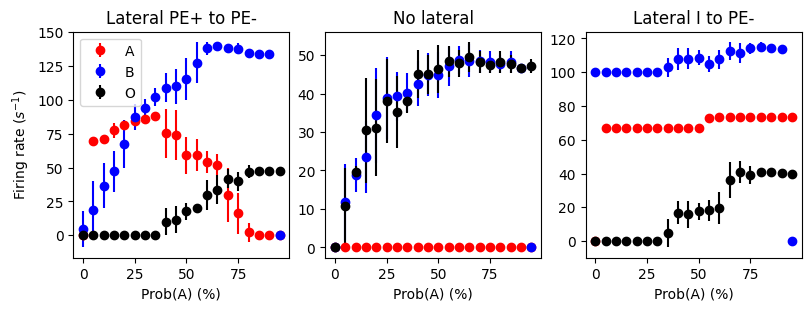

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), layout='compressed')
mask = np.isin(all_p_A, np.arange(0, 100, 5))  # (0, 5, 10, ..., 95)
for ax, key in zip(axs, rates_mean.keys()):
    for mean, std, label, color in zip(rates_mean[key], rates_std[key], 'ABO', 'rbk'):
        ax.errorbar(all_p_A[mask], mean[mask]/Hz, yerr=std[mask]/Hz, fmt=f'{color}o', label=label)
    ax.set_title(key)
    ax.set_xlabel('Prob(A) (%)')
axs[0].set_ylabel('Firing rate ($s^{-1}$)')
axs[0].legend()
print('Figure 9B')

Figure 10A,B


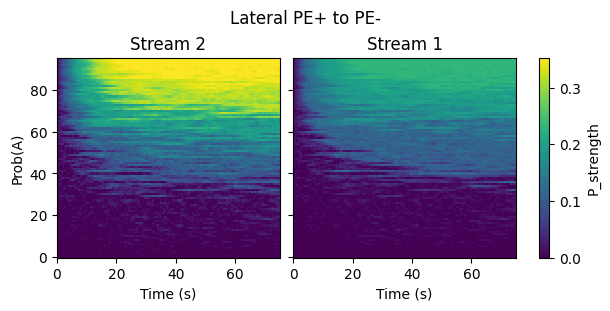

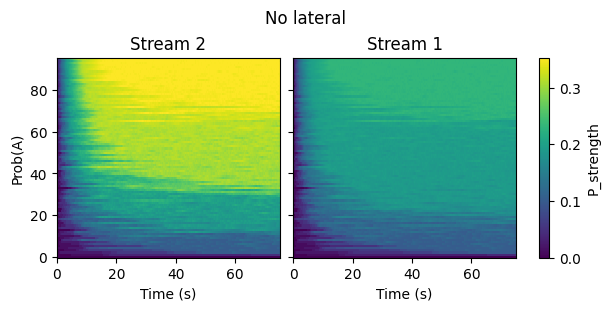

In [14]:
for key in ('Lateral PE+ to PE-', 'No lateral'):
    fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True, layout='compressed')
    for ax, stream in zip(axs, (1,0)):
        ax.set_title(f'Stream {stream+1}')
        ax.set_xlabel('Time (s)')
        m = ax.pcolormesh(np.linspace(0, runtime, w_pred[key].shape[2]), all_p_A, w_pred[key][stream], vmin=0, vmax=w_pred[key].max())
    plt.colorbar(m, ax=axs, label='P_strength')
    axs[0].set_ylabel('Prob(A)')
    plt.suptitle(key)
print('Figure 10A,B')

Figure 10C


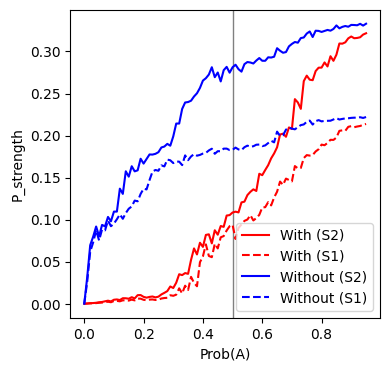

In [15]:
fig, ax = plt.subplots(figsize=(4,4))
ax.axvline(0.5, color='grey', lw=1)

for key, label, color in (['Lateral PE+ to PE-', 'With', 'r'], ['No lateral', 'Without', 'b']):
    ax.plot(all_p_A/100, np.mean(w_pred[key][1, :, steadystate:], 1), color, label=f'{label} (S2)')
    ax.plot(all_p_A/100, np.mean(w_pred[key][0, :, steadystate:], 1), f'{color}--', label=f'{label} (S1)')

plt.ylabel('P_strength')
plt.xlabel('Prob(A)')
plt.legend()
print('Figure 10C')

WARNING    /tmp/ipykernel_19023/3092359648.py:5: RuntimeWarning: invalid value encountered in divide
  ax.plot(all_p_A/100, np.log(np.mean(w_pred[key][1, :, steadystate:], 1)/np.mean(w_pred[key][0, :, steadystate:], 1)), color, label=label)
 [py.warnings]


Figure 10D


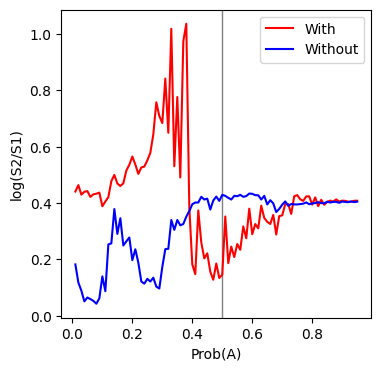

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
ax.axvline(0.5, color='grey', lw=1)

for key, label, color in (['Lateral PE+ to PE-', 'With', 'r'], ['No lateral', 'Without', 'b']):
    ax.plot(all_p_A/100, np.log(np.mean(w_pred[key][1, :, steadystate:], 1)/np.mean(w_pred[key][0, :, steadystate:], 1)), color, label=label)

plt.ylabel('log(S2/S1)')
plt.xlabel('Prob(A)')
plt.legend()
print('Figure 10D')

Figure 10E


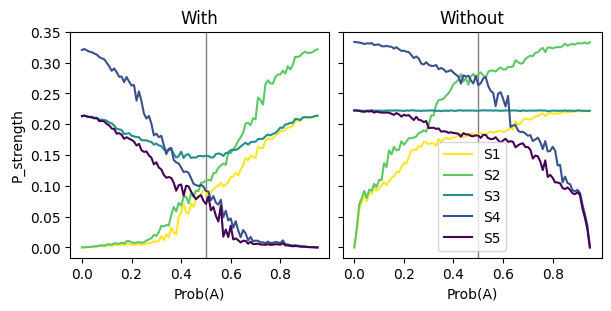

In [17]:
cmap = plt.cm.viridis_r
fig, axs = plt.subplots(1, 2, figsize=(6,3), layout='compressed', sharey=True)
for ax in axs:
    ax.axvline(0.5, color='grey', lw=1)
    ax.set_xlabel('Prob(A)')
axs[0].set_ylabel('P_strength')

for ax, key, label in zip(axs, ['Lateral PE+ to PE-', 'No lateral'], ['With', 'Without']):
    for stream in range(params['N_streams']):
        ax.plot(all_p_A/100, np.mean(w_pred[key][stream, :, steadystate:], 1), color=cmap(stream / (params['N_streams']-1)), label=f'S{stream+1}')
    ax.set_title(label)

axs[-1].legend()
print('Figure 10E')

Figure 10F


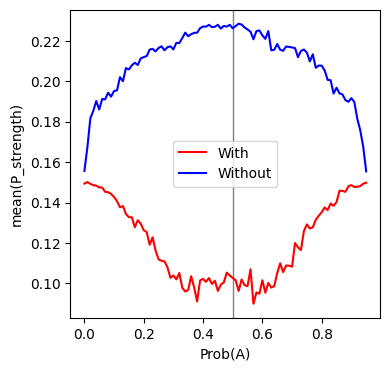

In [18]:
fig, ax = plt.subplots(figsize=(4,4))
ax.axvline(0.5, color='grey', lw=1)

for key, label, color in (['Lateral PE+ to PE-', 'With', 'r'], ['No lateral', 'Without', 'b']):
    ax.plot(all_p_A/100, np.mean(w_pred[key][:, :, steadystate:], (0,2)), color, label=label)

plt.ylabel('mean(P_strength)')
plt.xlabel('Prob(A)')
plt.legend()
print('Figure 10F')